# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных  
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [3]:
region_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
 region_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
region_three.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
region_one.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
region_two.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
region_three.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
# Удаляем строки с дублированными данными в колонке id
regions = [region_one, region_two, region_three]
for region in regions:
    region.drop(region.query('id.duplicated() == True').index, inplace=True)

In [10]:
region_one['id'].duplicated().sum()

0

In [11]:
region_two['id'].duplicated().sum()

0

In [12]:
region_three['id'].duplicated().sum()

0

In [13]:
# Выделяем целевые и независимые признаки в регионах
# Для выборок независимых признаков также удаляем колонку id, т.к. данные в ней будут мешать обучению моделей.
region_one_X = region_one.drop(['product','id'], axis=1)
region_one_y = region_one['product']
region_two_X = region_two.drop(['product','id'], axis=1)
region_two_y = region_two['product']
region_three_X = region_three.drop(['product','id'], axis=1)
region_three_y = region_three['product']

### Вывод:  
* Чтобы избежать ошибок, в датасетах были удалены строки с дублирующимися id.  
* Для каждого региона были выделены независимые и целевые признаки

# 2. Обучение и проверка модели

In [14]:
# Делим данные трёх регионов на обучающие и валидационные выборки
# Для удобства регион №1 будет называться alpha, а регионы №2 и №3 соответственно beta и gamma
alpha_X_train, alpha_X_valid, alpha_y_train, alpha_y_valid = train_test_split(region_one_X, region_one_y, test_size=0.25)
beta_X_train, beta_X_valid, beta_y_train, beta_y_valid = train_test_split(region_two_X, region_two_y, test_size=0.25)
gamma_X_train, gamma_X_valid, gamma_y_train, gamma_y_valid = train_test_split(region_three_X, region_three_y, test_size=0.25)

In [15]:
# создаем нашу модель линейной регрессии
model = LinearRegression()

In [16]:
# обучаем модель на данных региона №1
model.fit(alpha_X_train, alpha_y_train)
alpha_predicted = model.predict(alpha_X_valid)
mse_alpha = mean_squared_error(alpha_y_valid, alpha_predicted)
rmse_alpha = mse_alpha**0.5
alpha_mean = alpha_predicted.mean()
print(f'Регион №1. Средний запас предсказанного сырья: {alpha_mean}, RMSE = {rmse_alpha}')

Регион №1. Средний запас предсказанного сырья: 92.31628251842389, RMSE = 37.74842824848683


In [17]:
# обучаем модель на данных региона №2
model.fit(beta_X_train, beta_y_train)
beta_predicted = model.predict(beta_X_valid)
mse_beta = mean_squared_error(beta_y_valid, beta_predicted)
rmse_beta = mse_beta**0.5
beta_mean = beta_predicted.mean()
print(f'Регион №2. Средний запас предсказанного сырья: {beta_mean}, RMSE = {rmse_beta}')

Регион №2. Средний запас предсказанного сырья: 69.15761146599104, RMSE = 0.8945966761629139


In [18]:
# обучаем модель на данных региона №3
model.fit(gamma_X_train, gamma_y_train)
gamma_predicted = model.predict(gamma_X_valid)
mse_gamma = mean_squared_error(gamma_y_valid, gamma_predicted)
rmse_gamma = mse_gamma**0.5
gamma_mean = gamma_predicted.mean()
print(f'Регион №3. Средний запас предсказанного сырья: {gamma_mean}, RMSE = {rmse_gamma}')

Регион №3. Средний запас предсказанного сырья: 95.14739440099697, RMSE = 40.33026202654201


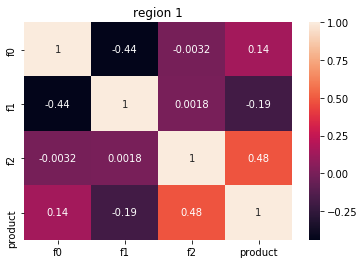

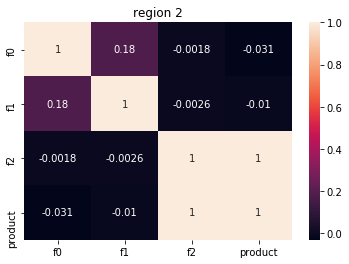

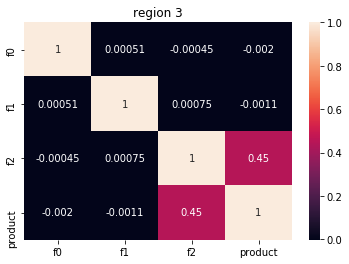

In [19]:
for i in range(len(regions)):
    ax = plt.axes()
    sns.heatmap(regions[i].corr(), annot = True)
    ax.set_title('region ' + str(i+1))
    plt.show()

### Вывод:  
* Мы разделили данные каждого региона на обучающую и валидационную выборки;    
* Обучили модель линейной регрессии на тренировочных данных каждого региона;  
* Посчитали среднее количество предсказанных запасов в каждом регионе, и посчитали среднеквадратическую ошибку;  
* В регионе №1. Средний запас предсказанного сырья: 92.516 тыс.баррелей, RMSE = 37.7387;  
* В регионе №2. Средний запас предсказанного сырья: 68.966 тыс.баррелей, RMSE = 0.8907;  
* В регионе №3. Средний запас предсказанного сырья: 95.0019 тыс.баррелей, RMSE = 39.94007;  
* Для проверки корреляции признаков мы построили тепловые карты данных для каждого региона. Удалось обнаружить высокую корреляцию между признако f2 и целевым признаком в регионе №2, потому среднеквадратическая ошибка в этом регионе меньше единицы.

# 3. Подготовка к расчёту прибыли

In [20]:
# Сохраняем ключевые значения для расчетов
regional_budget = 10_000_000_000 # Бюджет на разработку скважин в регионе
one_barrel_income = 450  # Доход с одного барреля сырья 
income_per_unit = 450_000 # Доход с каждой единицы продукта 
MINES_COUNT = 200 # Количество лучших шахт для расчета прибыли

In [21]:
# Рассчитываем достаточный объём сырья для безубыточной разработки новой скважины
regional_development = regional_budget/income_per_unit
staple_volume = regional_development / MINES_COUNT
round(staple_volume,2)

111.11

In [22]:
# Сравнение средних запасов предсказанного сырья в регионах по сравнению с объёмом достаточным для безубыточной разработки
means = [alpha_mean, beta_mean, gamma_mean]

In [23]:
def compare_volume(region_volumes):
    for i in range(len(region_volumes)):
        if region_volumes[i] < staple_volume:
            print(f'Средний предсказанный запас сырья в регионе {i+1} меньше объёма достаточного для безубыточной разработки на {round(staple_volume - region_volumes[i], 2)}')
        else:
            print(f'Средний предсказанный запас сырья в регионе {i+1} больше объёма достаточного для безубыточной разработки на {round(region_volumes[i] - staple_volume, 2)}')

In [24]:
compare_volume(means)

Средний предсказанный запас сырья в регионе 1 меньше объёма достаточного для безубыточной разработки на 18.79
Средний предсказанный запас сырья в регионе 2 меньше объёма достаточного для безубыточной разработки на 41.95
Средний предсказанный запас сырья в регионе 3 меньше объёма достаточного для безубыточной разработки на 15.96


### Вывод:  
* Мы сохранили ключевые значения для расчетов в переменных;  
* Рассчитали необходимое количество сырья для безубыточной разработки новой скважины - это 111.11 баррелей;  
* После сравнения средних предсказанных моделю запасов сырья, мы выяснили что среднее значение запасов во всех трех регионах меньше необходимого количества для безубыточной разработки;  
* Ближе всего к необходимому количеству предсказанные запасы в регионе №3, меньше всего предсказанных запасов в регионе №2.

# 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [25]:
# Функция для расчета прибыли по выбранным скважинам и предсказаниям модели
def revenue(target, predictions):
    target = pd.Series(target).reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    predictions_s = predictions.sort_values(ascending=False)[:MINES_COUNT].index
    selected = target[predictions_s]
    revenue = selected.sum() * income_per_unit - regional_budget
    return round(revenue, 2)

In [26]:
revenue(alpha_y_valid, alpha_predicted)

3225668363.55

In [27]:
revenue(beta_y_valid, beta_predicted)

2415086696.68

In [28]:
revenue(gamma_y_valid, gamma_predicted)

2533208441.87

# 5. Расчёт прибыли и рисков 

In [36]:
def bootstrap(target, probabilities, iterations, sample_size):
    state = np.random.RandomState(12345)
    values = []
    for i in range(iterations):
        target_subsample = target.sample(n=sample_size, random_state=state, replace=True)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=values.sem())
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    return round(mean,2), confidence_interval, round(risk*100, 2), quantile_interval

In [37]:
alpha_mean, alpha_interval, alpha_risk, alpha_quantile = bootstrap(alpha_y_valid.reset_index(drop=True), alpha_predicted, 1000, 500)
print('Регион №1 средняя выручка = ', alpha_mean)
print('Регион №1 95 %ый доверительный интервал по стьюденту = ', alpha_interval)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', alpha_quantile)
print(f'Регион №1 Риск убытков: {alpha_risk}%')

Регион №1 средняя выручка =  397672150.08
Регион №1 95 %ый доверительный интервал по стьюденту =  (381284705.49558306, 414059594.659577)
Регион №1 95 %ый доверительный интервал по квантилям =  (-158764516.25074998, 909844786.4617499)
Регион №1 Риск убытков: 6.2%


In [38]:
beta_mean, beta_interval, beta_risk, beta_quantile = bootstrap(beta_y_valid.reset_index(drop=True), beta_predicted, 1000, 500)
print('Регион №2 средняя выручка = ', beta_mean)
print('Регион №2 95 %ый доверительный интервал по стьюденту = ', beta_interval)
print('Регион №2 95 %ый доверительный интервал по квантилям = ', beta_quantile)
print(f'Регион №2 Риск убытков: {beta_risk}%')

Регион №2 средняя выручка =  482507465.0
Регион №2 95 %ый доверительный интервал по стьюденту =  (470025059.155097, 494989870.848423)
Регион №2 95 %ый доверительный интервал по квантилям =  (96011012.57575001, 897233498.308)
Регион №2 Риск убытков: 0.9%


In [40]:
gamma_mean, gamma_interval, gamma_risk, gamma_quantile = bootstrap(gamma_y_valid.reset_index(drop=True), gamma_predicted, 1000, 500)
print('Регион №3 средняя выручка = ', gamma_mean)
print('Регион №3 95 %ый доверительный интервал по стьюденту = ', gamma_interval)
print('Регион №2 95 %ый доверительный интервал по квантилям = ', gamma_quantile)
print(f'Регион №3 Риск убытков: {gamma_risk}%')

Регион №3 средняя выручка =  375985896.31
Регион №3 95 %ый доверительный интервал по стьюденту =  (359174564.45022887, 392797228.17039114)
Регион №2 95 %ый доверительный интервал по квантилям =  (-145543409.806, 890085754.1269999)
Регион №3 Риск убытков: 8.0%


# Вывод:  
* Согласно прогнозам сделанным с помощью техники Bootstrap, наиболее прибыльным будет разработка месторождений в регионе №2. В данном регионе самые высокие показатели средней выручки и 95%-ного доверительного интервала. Также в регионе №2 самый низкий риск убытков. 